CS7317 Using Machine Learning Tools 2020, Assignment 2: Breast Cancer Classification

This is the template for the submission of Assignment 2. Keep the numbering, headings and sequence intact. Add the code and text answers (Markdown cells) below the respective numbered heading.

Student name:
Student ID:

Initialise environment, libraries, settings, etc.:

In [41]:
# importing essential libraries
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from sklearn.metrics import auc, classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pylab import rcParams
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import scikitplot as skplt      # import schikitplot using pip install scikit-plot
import warnings

Load the data set:

In [2]:
cancer = datasets.load_breast_cancer()  # loadinf dataset

In [3]:
cancer.keys() # getting elements of dataset

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
print(cancer['DESCR'])  # reading discription of dataset

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
# making dataframe
df = pd.DataFrame(np.c_[cancer['data'],cancer['target']],columns=np.append(cancer['feature_names'],['target']))
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [6]:
df=df.sort_values(by='target', ascending=True)
df['target'].head(213)

0      0.0
190    0.0
193    0.0
194    0.0
196    0.0
      ... 
17     0.0
16     0.0
517    0.0
7      0.0
375    1.0
Name: target, Length: 213, dtype: float64

In [7]:
# splitting dataframe classwise
df_malignant=df.iloc[0:211]
df_benign=df.iloc[212:569]

### Q1	Understand the dataset (15%)

### Q1.1
Question: Briefly describe what each of the 10 parameters of the cell nuclei mean, using the documentation of the dataset and the example image in Figure 1. What could be the reasons for using the mean, standard error and maximum of each of the 10 parameters?

### Answer:
- Snake : The actual boundary of cell nucleus is located by an active contour model known as 'snake'.
- Radius: The radius of an individual nucleus is measured by averaging the length of the radial line segments defined by the centroid of the snake and the individual snake points.
- Perimeter: The total distance between the snake points constitute the nuclear perimeter.
- Area: Nuclear area is measured simply by counting the number of pixels on the interior of the snake and adding one half of the pixels in perimeter.
- Compactness: Perimeter and area are combined to give a measure of the compactness of the cell nuclie using the formula $perimeter^2/area$.
- Smothness: It is measured by calculating the difference between the length of a radial line and the mean length of the lines surrounding it.
- Concavity: It is a shape information. To measure it, chords are drawn between non-adjacent snake points and measure the extent to which the actual boundary of the nucleus lies on the inside if each chord.
- Concave Points: It is similar to Concavity but measures only the number, rather than the magnitude, of contour concavities.
- Symmetry: First we find the major axis or the longest chord though center and then measure the length difference between lines perpendicular to the major axis to the cell boundary in both direction.
- Fractal Dimension: It is approximated using the coastline approximation which is dimensions along the edges of the cell nucleus to judge the amount of malignancy in the cell.
- Texture: It is measured by finding thr variance of the gray scale intensities in the component pixels.

The mean, standard error and maximum of each feature is used for each image as maximum values are most intuitively  useful for the problem, since only few malignant cells may occur in a given sample

### Q1.2
Plot histograms of each of the 30 features, using two distributions, one for each class, in each diagram. Use 3 figures with 10 subplots each.

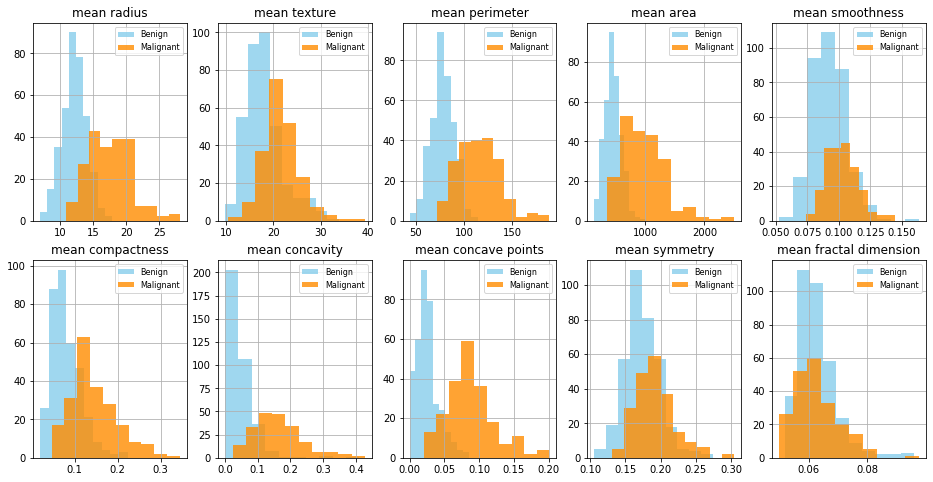

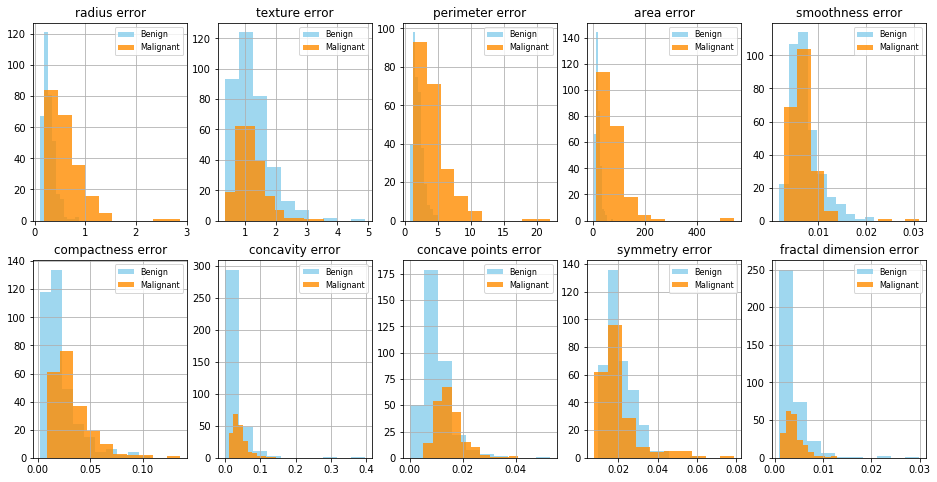

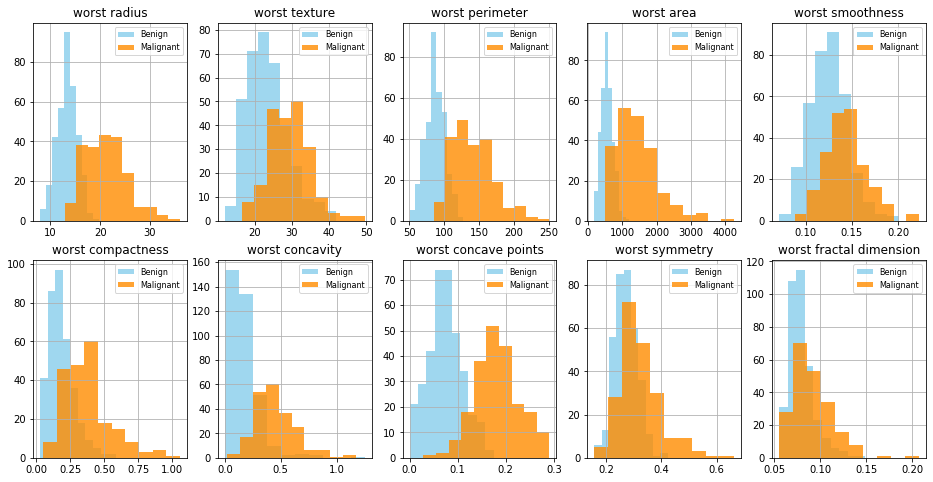

In [8]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=False,figsize=(16,8))  # making subplots
m=0
for i in range(2):
    for j in range(5):
        column_name=df.columns[m]
        ax[i,j].set_title(column_name)
        df_benign.iloc[:,m].hist(bins=10,alpha=0.8, color="skyblue", label="Benign",ax=ax[i,j])
        df_malignant.iloc[:,m].hist( bins=10,alpha=0.8, color="darkorange", label="Malignant",ax=ax[i,j])
        ax[i,j].legend(prop={'size': 8})
        m=m+1

fig1, ax = plt.subplots(2, 5, sharex=False, sharey=False,figsize=(16,8))
n=10
for a in range(2):
    for b in range(5):
        column_name=df.columns[n]
        ax[a,b].set_title(column_name)
        df_benign.iloc[:,n].hist(bins=10,alpha=0.8, color="skyblue", label="Benign",ax=ax[a,b])
        df_malignant.iloc[:,n].hist( bins=10,alpha=0.8, color="darkorange", label="Malignant",ax=ax[a,b])
        ax[a,b].legend(prop={'size': 8})
        n=n+1

fig2, ax = plt.subplots(2, 5, sharex=False, sharey=False,figsize=(16,8))
o=20
for p in range(2):
    for q in range(5):
        column_name=df.columns[o]
        ax[p,q].set_title(column_name)
        df_benign.iloc[:,o].hist(bins=10,alpha=0.8, color="skyblue", label="Benign",ax=ax[p,q])
        df_malignant.iloc[:,o].hist( bins=10,alpha=0.8, color="darkorange", label="Malignant",ax=ax[p,q])
        ax[p,q].legend(prop={'size': 8})
        o=o+1
# using three figures to plot 30 subplots

Answer:

### Q1.3
Plot receiver-operating-characteristic (ROC) curves of the individual features into 3 figures, one figure for each of the groups of 10.

In [9]:
tpr_direct = []      # true positive rate of each feature
fpr_direct = []      # false positive rate if each feature
auc_direct = []      # Area under curve for each feature
# auc1 = []
for i in range(0,10):       # for columns with mean values
    y_df = df.iloc[:,i]
    fpr, tpr, thresholds = roc_curve(df['target'],y_df)
    tpr_direct.append(tpr)
    fpr_direct.append(fpr)
    auc1= auc(tpr, fpr)
    auc_direct.append(auc1)
    
d1 = np.linspace(0,1)
d2 = np.linspace(0,1)  # to plot x=y line through the graph

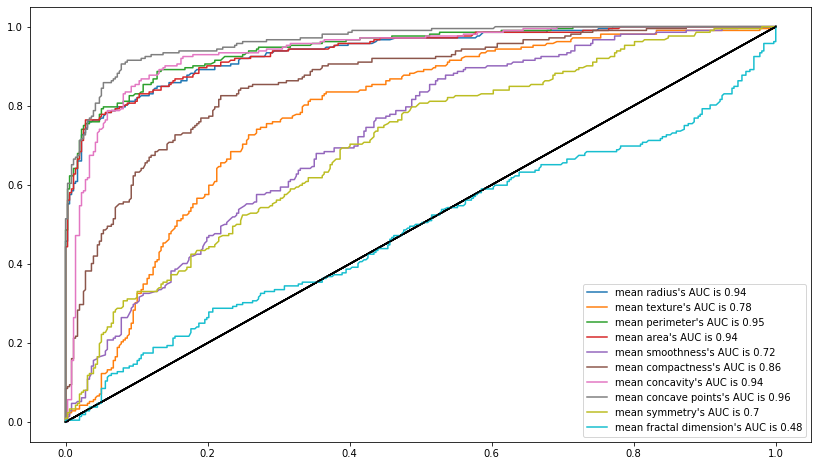

In [10]:
rcParams['figure.figsize'] = 14, 8
auc_is = '\'s AUC is '

for i in range (0,len(tpr_direct)):       # plotting ROC curve
    col=str(df.columns[i]) +auc_is+ str(round(auc_direct[i],2))
    plt.plot(tpr_direct[i],fpr_direct[i],label=col)
    plt.plot(d1,d2, color='black')
    plt.legend()


In [11]:
tpr_direct1 = []
fpr_direct1 = []
auc_direct1 = []
# auc1 = []
for i in range(10,20):        # for feaure with error values
    y_df = df.iloc[:,i]
    fpr, tpr, thresholds = roc_curve(df['target'],y_df)
    tpr_direct1.append(tpr)
    fpr_direct1.append(fpr)
    auc1= auc(tpr, fpr)
    auc_direct1.append(auc1)

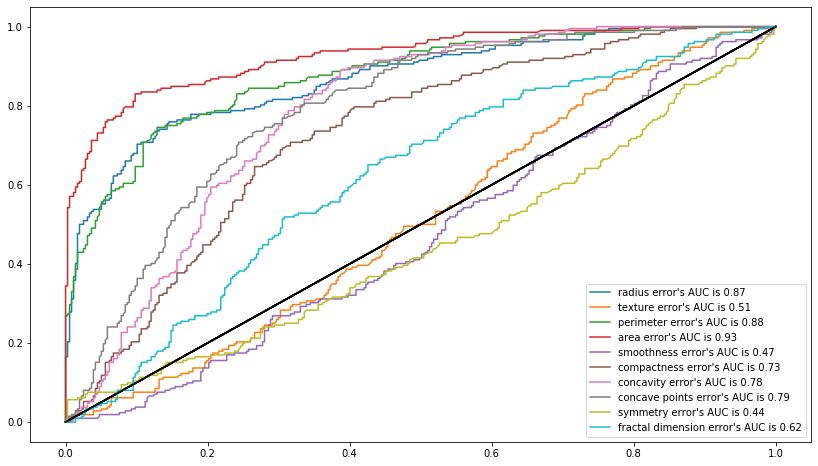

In [12]:
rcParams['figure.figsize'] = 14, 8
auc_is = '\'s AUC is '

for i in range (0,len(tpr_direct1)):
    col=str(df.columns[i+10]) +auc_is+ str(round(auc_direct1[i],2))
    plt.plot(tpr_direct1[i],fpr_direct1[i],label=col)
    plt.plot(d1,d2, color='black')
    plt.legend()

In [13]:
tpr_direct2 = []
fpr_direct2 = []
auc_direct2 = []

for i in range(20,30):    # for feature with 'worst' values
    y_df = df.iloc[:,i]
    fpr, tpr, thresholds = roc_curve(df['target'],y_df)
    tpr_direct2.append(tpr)
    fpr_direct2.append(fpr)
    auc1= auc(tpr, fpr)
    auc_direct2.append(auc1)

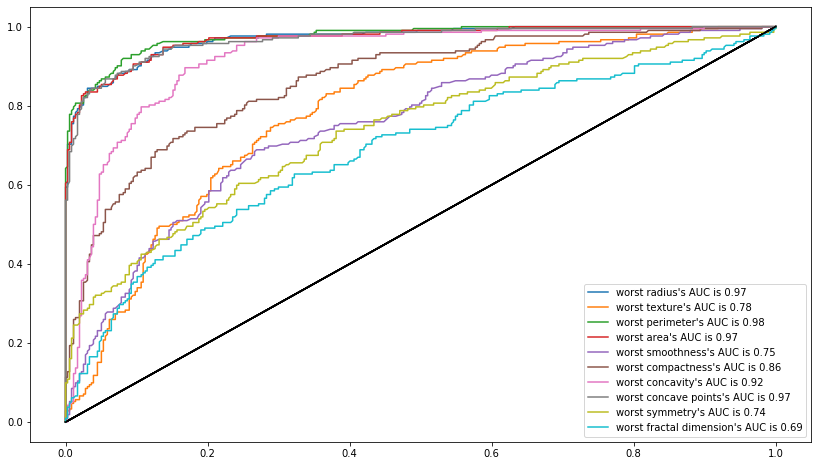

In [14]:
rcParams['figure.figsize'] = 14, 8
auc_is = '\'s AUC is '

for i in range (0,len(tpr_direct2)):
    col=str(df.columns[i+20]) +auc_is+ str(round(auc_direct2[i],2))
    plt.plot(tpr_direct2[i],fpr_direct2[i],label=col)
    plt.plot(d1,d2, color='black')
    plt.legend()

### Q1.4
Question: Which of the parameters seems promising based on the histograms and ROC curves? Justify your choice while referring to the particular features in the figures that indicate a good separation. Choose your top five candidate features.

### Answer: 
To choose best candidate fearures, we are going to look for the Area Under the Curve as more the area under the curve, more is the precision and recall score and more promising the feature is in getting the appropiriate results. Also for these below selected features, there is not much overlapping in their histograms.
So accroding to that Top 5 feaures  are:
1. Worst Perimeter
2. Mean Concave Points
3. Worst Area
4. Worst Radius
5. Worst Concave Points

### Q1.5
Analysis Point: Calculate the mean of all instances of the malignant class (centre of mass in high dimensional feature space) and the mean of all instances of the benign class. Save the mean between those two as the “Analysis Point”. It is a point in the feature space that is approximately between both classes.

In [15]:
class my_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

dict_analysis_point = my_dictionary()    # instance of class
analysis_point=[]                        # list of analysis points
for m in range(0,30):
    mean_malignant=df_malignant.iloc[:,m].mean()
    mean_benign=df_benign.iloc[:,m].mean()
    class_mean=round((mean_malignant+mean_benign)*0.5,2)
    dict_analysis_point.add(df.columns[m], class_mean)
    analysis_point.append(class_mean)
    
for (key,value) in dict_analysis_point.items():     # printing analysis points
    print(key,value)

mean radius 14.81
mean texture 19.76
mean perimeter 96.78
mean area 721.53
mean smoothness 0.1
mean compactness 0.11
mean concavity 0.1
mean concave points 0.06
mean symmetry 0.18
mean fractal dimension 0.06
radius error 0.45
texture error 1.22
perimeter error 3.16
area error 46.96
smoothness error 0.01
compactness error 0.03
concavity error 0.03
concave points error 0.01
symmetry error 0.02
fractal dimension error 0.0
worst radius 17.27
worst texture 26.42
worst perimeter 114.26
worst area 991.84
worst smoothness 0.13
worst compactness 0.28
worst concavity 0.31
worst concave points 0.13
worst symmetry 0.3
worst fractal dimension 0.09


### Q2	Train a decision tree classifier (15%)

### Q2.1
Construct a decision tree classifier using the gini criterion and random_state=0. Below, you will perform a hyper parameter search of max_depth and min_samples_leaf. Check the following remaining parameters of the classifier and either keep the default value or select a different value: min_samples_split, min_weight_fraction_leaf, max_features, max_leaf_nodes, min_impurity_decrease, min_impurity_split and class_weight. Question: Describe each choice briefly in one sentence.

In [16]:
X = df.iloc[:,0:30]     
Y = df['target']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.38, random_state=0)  # spitting dataset into trainings and test sets

In [17]:
tree = DecisionTreeClassifier(criterion = 'gini', random_state=0, max_depth=7, min_samples_leaf=1)
tree.fit(x_train,y_train)    # training the model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [18]:
y_predict = tree.predict(x_test)
accuracy_score(y_test, y_predict)

0.9769585253456221

In [19]:
y_pred=tree.predict(x_test)
precision_score(y_test, y_pred)

0.9788732394366197

In [20]:
recall_score(y_test, y_pred)

0.9858156028368794

## Answer:
###### _For hyperparameter search I've randomly entered different values for max_depth and min_samples_leaf before fitting and calculated the accuracy score for my selection of hyperparameters. Finally selected the values with good accuracy score_

__max_depth :__ max depth is the maximum depth to which the tree to grow, we are determining this value by randomly adding values  but refraining from putting too large value as classifier might overfit because of that.

__min_samples_leaf :__ min samples in a leaf is the minimum number of datapoints allowed in a leaf node. If the value is too low then the model tends to overfit.

__min_samples_split:__ We are not electing any value and the default value "2" is being selected. This determines the min values required to split a node. We are selecting default value because randomly selecting value can cause underfit overfit.

__min_weight_fraction_leaf:__ The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. We are going with default value because we have already given min_samples_leaf and this requires fraction of sample in each leaf.

__max_features:__ For starters, we are going with all the features because we might eliminate important feature if we use this hyperparameter.

__min_impurity_decrease:__ It also controls how deep the tree goes and we have already given max_depth so we are not going to change it.

__class_weight:__ We can use this in later stages beacause our classes are at 38% to 62% ratio which is somewhat balanced but we might need more balanced dataset in later stages so that out model would not become biased.

### Q2.2
Build a pipeline including any pre-processing steps that you think are necessary. Question: Do the data need to be scaled for decision tree classification? Are the different class sizes a problem, and if so what are you doing about it?

In [46]:
dt_pipeline_steps = [('scaler', StandardScaler()), ('dt_classifier', DecisionTreeClassifier(criterion='gini',random_state=0,max_depth=7,min_samples_leaf=1))]
pipeline=Pipeline(dt_pipeline_steps)

In [47]:
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dt_classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=7, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=0,
                                        splitter='best'))],
         verbose=False)

In [48]:
accuracy=pipeline.score(x_test,y_test)
print(accuracy)

0.9769585253456221


In [49]:
y_pred_=pipeline.predict(x_test)
precision_score(y_test, y_pred_)

0.9788732394366197

In [25]:
recall_score(y_test, y_pred_)

0.9858156028368794

### Answer:
- Even if we scale the data, there is no change in accurace score, precision and recall score so there is no need to scale the data in this case of Decision Tree classifier.
- The data is somewhat balanced as Malignant classes results are 212 and 357 for Benign which is 38% to 62% ratio respectively but we can balance it more accurately by setting a hyperparameter class_weight='balanced' in Decision Tree Classifier which significantly reduces the chances of model becoming biased.

### Q2.3
Perform a grid search using five-fold cross validation over values of the maximum depth (max_depth) and the minimum number of samples per leaf (min_samples_leaf). Choose the value range yourself. Question: What is the rationale for your choice?

In [26]:
i=df["mean radius"]
x=df[["target"]]
max_depth = [int(x) for x in range(1, 10)]
min_samples_leaf = [int(x) for x in range(1, 10)]

# Create the dictionary 
grid_values = {'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf}

In [27]:
gridsearch=GridSearchCV(DecisionTreeClassifier(criterion='gini',random_state=0,class_weight='balanced'),param_grid=grid_values,cv=5,n_jobs=-1)

In [28]:
gridsearch.fit(x_train,y_train)

/home/ishu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8

In [29]:
gridsearch.best_params_

{'max_depth': 7, 'min_samples_leaf': 1}

- Now we will use these hyperparameter values in our pipeline for best possible results

- There is a significant increase in recall score after using best parameters from grid search

In [73]:
recall_score(y_test, y_pred__)

0.9858156028368794

### Answer:
- In the part 2.1, I tried different values for max_depth and min_samples_leaf starting from 1 and after max_depth=7 there was no significant effect on scores but for min_samples_leaf, scores started decreasing  after 3 so based on that inference I chose range of 1 to 10 for both max_depth and min_samples_leaf in GridSearch.

### 3	Evaluate the decision tree classifier (20%)

### Q3.1
Calculate the confusion matrix, precision and recall of the final classifier. Question:  Based on these metrics, what is the chance of failing to detect a sample with cancer? What are the strengths and weaknesses of the classifier?

In [30]:
confusion_matrix(y_test,y_pred_)  # confusion matrix

array([[ 73,   3],
       [  2, 139]])

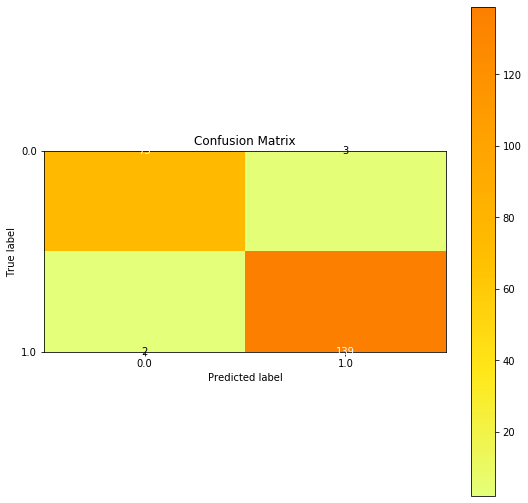

In [31]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_, normalize=False, figsize=(9,9),cmap='Wistia')
plt.show()

In [32]:
precision_score(y_test, y_pred_)

0.9788732394366197

In [33]:
recall_score(y_test, y_pred_)

0.9858156028368794

### Answer:
- Based on the metrics our False Negative value is 2 and and out True Positive value is 139 so chances of failing to detect sample with cancer is $FN/(TP+FN)*100=2/(139+2)*100=1.4184397$% or also it can be calculated by this method: 1-Recall_score
##### Classifier Strength:
1. It's good for binary classification as in our case.
2. Does not require much preprocessing of the dataset.
3. Scaling is not necessary for decision tree classifier
4. Easy to understand
##### Classifier Weakness
1. Not appropiriate for predicting continous values.
2. Can get biased if classes are not balanced.
3. It is computationally expensive.

### Q3.2
Display decision tree using plot_tree(). Question: Describe the structure. What do each of the entries in the first node mean? Are the features in the decision tree matching the initial candidate features from Section 1?

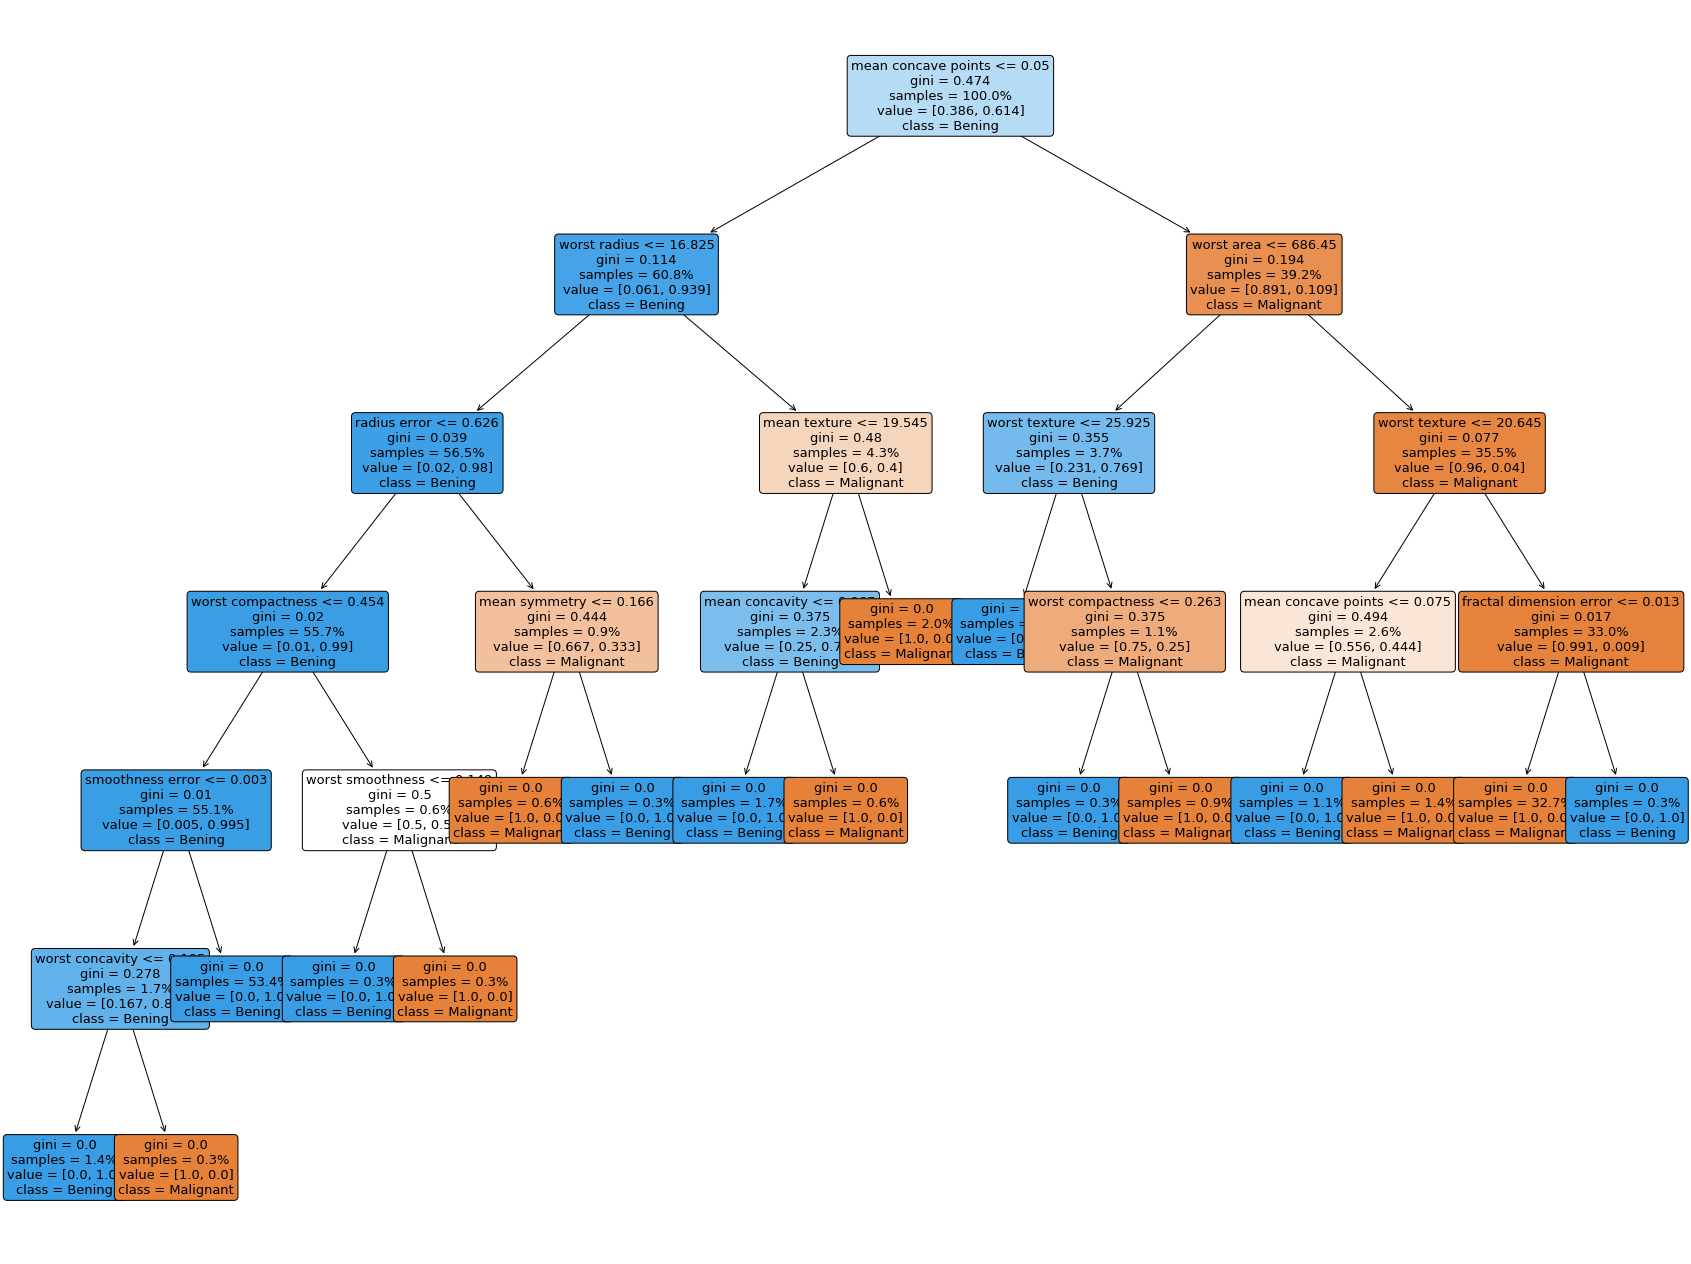

In [34]:
fig, ax = plt.subplots(figsize=(30, 23), facecolor='white')
a = plot_tree(tree, 
              feature_names=df.columns, 
              class_names=['Malignant','Bening'], 
              filled=True, 
              rounded=True, 
              fontsize=13,proportion=True, ax=ax)

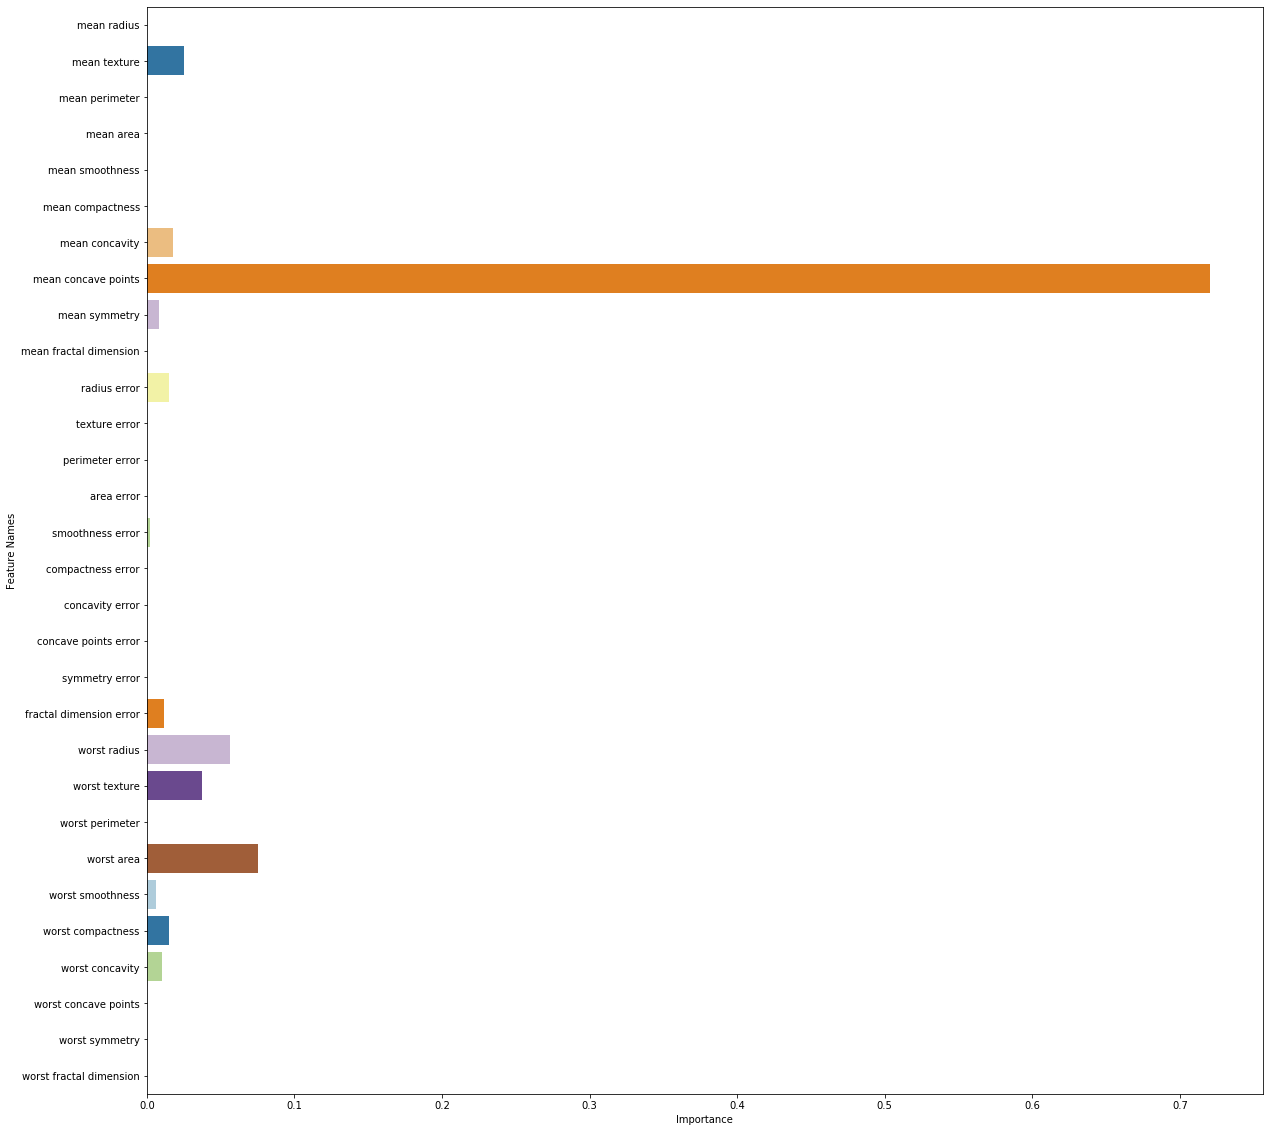

In [35]:
df_tree_plot = pd.DataFrame({'Feature Names' : df.columns[0:30],
                       'Importance' : tree.feature_importances_})
plt.figure(figsize=(20,20))
ax = sns.barplot(x="Importance", y='Feature Names', data=df_tree_plot,palette='Paired') 

### Answer:
__Structure:__ It is a decision tree with one root node and 15 leaf nodes and it has couple of child nodes in between.
- First we start at the root node at depth 0 and we encounter mean_concave_point. At this, it ask whether thr mean concave point is less than or equal to 0.05 or not. Based on the answer it moves down to its child node, which are worst radius and worst area and on those nodes it also asks the same question whether the value is less than that certain value or not until it reaches the leaf node.
- Now there is gini impurity wich decides the optimal split at that node. It tells us what is the probability of misclassifying an observation meaning we will select those features which further reduces the gini impurity as we go down the tree.
- Node's samples entry counts on how many training instances it applies to.
- A node's value entry tells us on how many training instances of each class this nodes applies to. And in our case it is telling us the proportion or ratio of those instances.
- A node's class tells us the class of the instance.

__Feature Comparison:__  In this case as we can see from the graph which tells us about the Importance of feature from decision tree, our Top 5 features are:
1. Mean concave points
2. Worst area
3. Worst radius
4. Worst texture
5. Mean texture

And the Top 5 feaures we got in __1.4__ are:
1. Worst Perimeter
2. Mean Concave Points
3. Worst Area
4. Worst Radius
5. Worst Concave Points

__So 3 features matches between them which are:__
1. Mean concave points
2. Worst area
3. Worst radius

### Q3.3
Display the decision boundaries (use function predict()) together with a scatter plot of the data using two features at a time. 

In [36]:
cancer_features_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_target_df = pd.DataFrame(cancer.target, columns=["target"])
cancer_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [39]:
important_features=[]
column_index=[]
for importance,Fname in sorted(zip(pipeline.steps[1][1].feature_importances_, x_train.columns),reverse=True)[:5]:
    important_features.append(Fname)
for n in important_features:
    col=cancer_features_df.columns.get_loc(n)
    column_index.append(col)    

print("Top 5 most important columns are\n")# code here
for Fname in important_features:
    print(Fname)
print("\nThe index of top 5 important feature is:",column_index)

Top 5 most important columns are

mean concave points
worst area
worst radius
worst texture
mean texture

The index of top 5 important feature is: [7, 23, 20, 21, 1]


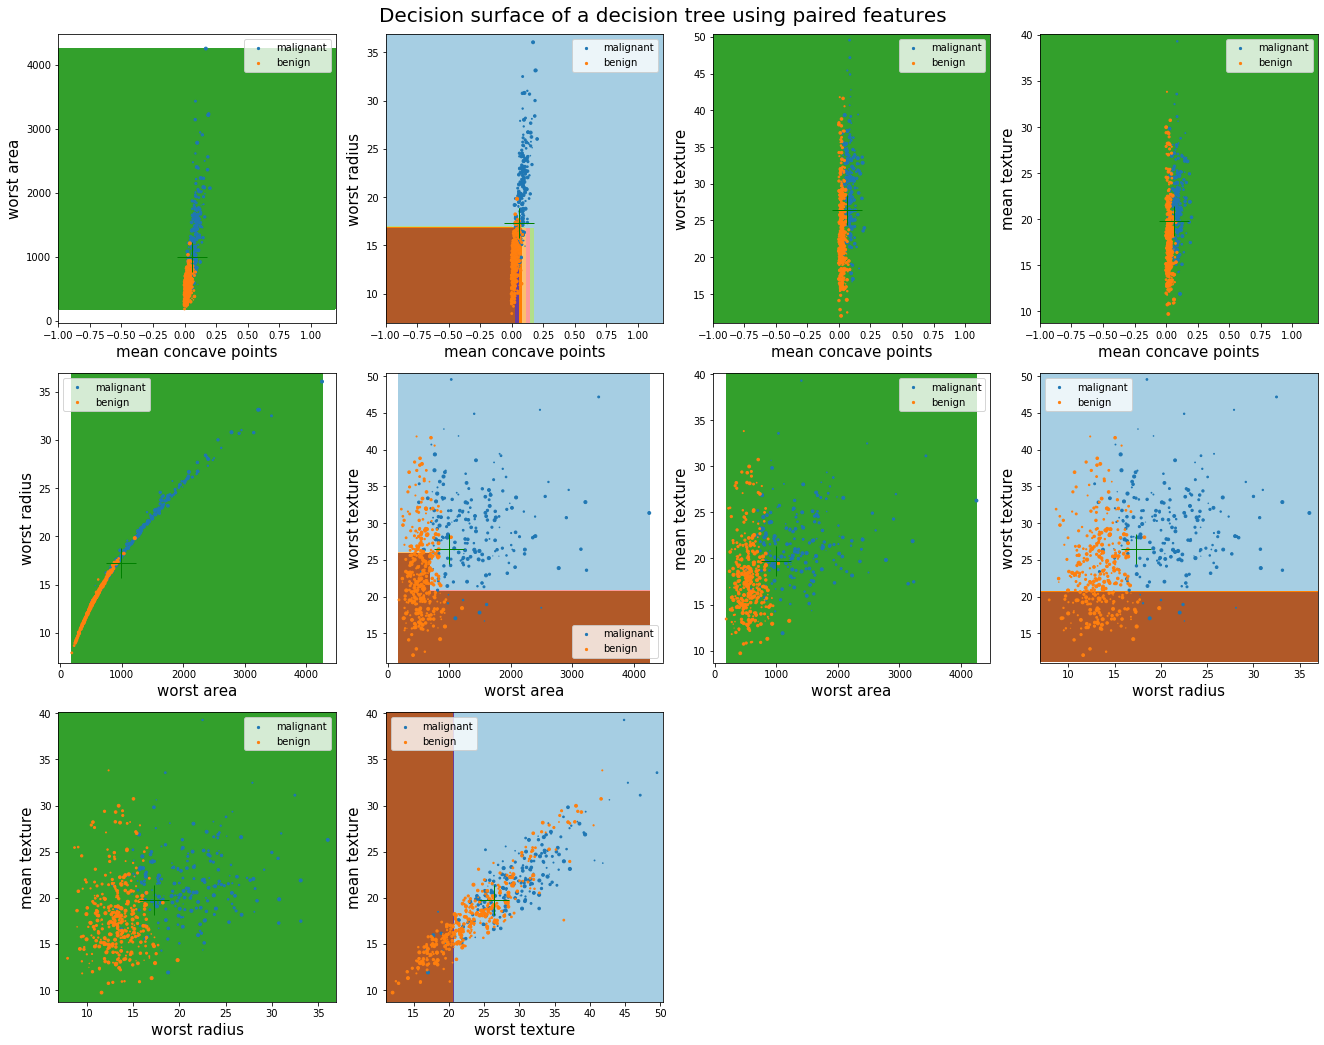

In [42]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 18.5)
import numpy as np
warnings.filterwarnings("ignore")


# Parameters
n_classes = 2
step_plot = .2

f1=column_index[0]
f2=column_index[1]
f3=column_index[2]
f4=column_index[3]
f5=column_index[4]
levels=np.arange(-0.1,10,0.1)

for pairid, pair in enumerate([[f1,f2] , [f1, f3], [f1, f4],[f1, f5],[f2, f3],
                                [f2, f4],[f2,f5], [f3,f4 ],[f3, f5], [f4, f5]]):
    # We only take the two corresponding features
    X = cancer.data[:, pair]
    y = cancer.target

    # Plot the decision boundary
    plt.subplot(4, 4, pairid + 1)
    # Make a meshgrid
    xmin, xmax = X[:, 0].min()-1 , X[:, 0].max()+1 
    ymin, ymax = X[:, 1].min()-1 , X[:, 1].max()+1 
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step_plot),
                         np.arange(ymin, ymax, step_plot))
    midpoint=((X[:, 1].mean(),X[:, 0].mean()))

    #Creating a new array to put the values of analysis point for the respective features by multiplying with analysis point 
    rows=xx.shape[0]*xx.shape[1]
    new_array=[]
    for i in range(rows):
        new_array.append([1]*30)
    new_array=np.array(new_array)
    new_array=np.c_[new_array]
    
    #Multiplying analysis point with new array
    analysis_point_array=np.array(analysis_point)
    new_array=new_array*analysis_point_array
    new_array[:,pair[0]]=xx.ravel()
    new_array[:,pair[1]]=yy.ravel()

    
    
    #Predict and plot contours
    Z = pipeline.predict(new_array)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z,cmap='Paired')
    
    #labling the columns
    plt.xlabel(cancer.feature_names[pair[0]],size=15)
    plt.ylabel(cancer.feature_names[pair[1]],size=15)
    plt.axis("tight")

    # Plot the training points
    for i in zip(range(n_classes)):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1],levels,label=cancer.target_names[i],
                    cmap='Paired')
    plt.axis("tight")
    plt.plot(analysis_point_array[pair[0]],analysis_point_array[pair[1]],marker='+',markersize=30,color="Green")
    plt.legend()
    plt.tight_layout()

plt.suptitle("Decision surface of a decision tree using paired features", size=20, y=1.010)

plt.show()

In [44]:
type(analysis_point_array)

numpy.ndarray

### Q3.4
Question: Is the class differentiation well characterised by the node thresholds or is it modelling the boundary using a rigid or stair case pattern? Why are there few 2D scatterplots with only one class shown as prediction contour?

### Answer:

### Q4	Train a support vector classifier with RBF kernel (15%)

### Q4.1
Construct a support vector classifier with a radial basis function kernel. Below, you will perform a hyper parameter search of C and gamma. Check the following remaining parameters of the classifier and either keep the default value or select a different value: tol, class_weight and max_iter. Question: Describe each choice briefly in one sentence.

In [54]:
svc = SVC(C=1000, gamma='scale', kernel='rbf')
svc.fit(x_train,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
ySVC_pred = svc.predict(x_test)
accuracy_score(y_test, ySVC_pred)

0.9539170506912442

### Answer:
- __C:__ It is regularisation parameter which imposes penalty. It's strength is inversly proportional to the value if C. So we took high value of C as we dont want to impose much penalty on our model
- __gamma:__ It defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'. which can be seen in the decision boundary plot.
- __class_weight:__ The default value is balanced. Our data is somewhat balanvced with 38% to 62% class ratio.
- __tol:__ It is the tolerence for the stopping criterion whose default value is __1e-3__
- __max_iter:__ Hard limit on iterations within solver, or -1 for no limit. And if we limit it the accurace score falls so we will use default value.

### Q4.2
Build a pipeline including any pre-processing steps that you think are necessary. Question: Do the data need to be scaled for support vector classification? Are the different class sizes a problem, and if so what are you doing about it?

In [56]:
pipeline_steps = [('scaler', StandardScaler()), ('svc', SVC(C=1,kernel='rbf',gamma='auto'))]
pipeline1 = Pipeline(pipeline_steps)

In [57]:
pipeline1.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [58]:
y_prediction = pipeline1.predict(x_test)
accuracy_score(y_test, y_prediction)

0.9769585253456221

In [66]:
precision_score(y_test, y_prediction)

0.9857142857142858

In [59]:
recall_score(y_test, y_prediction)

0.9787234042553191

### Answer:
- In SVC, our data needs to be scaled as if one feature has bigger values then it will dominate the other feature which has low values in calculating the distance. After scaling the data in SVC the accuracy is increased form 95% to 97.69%. So, it is playing a quite important role.
- Yes it is problem because if the data is imbalanced, model wil get biased. We can handle this by using gamma which acts as a regularisation parameter. If the model overfits we can reduce the value of gamma and if the model is underfits we can increase its value.So a small gamma value will make the bell curves encomassing the data set wider so the instances will have a larger range of influence and the decision boundry becomes smoother and wide.Whereas increasing the gamma value will make the bell-curve narrower which results in instance's range of influence to be smaller ,thus the decision boundry will become more irregular and uncertain.Another method is to reduce the C value in case the model is overfitting.

### Q4.3
Perform a grid search using five-fold cross validation over values of the regularisation parameter C and the kernel coefficient gamma. Choose the value ranges yourself. Question: What is the rationale for your choice?

In [60]:
hyper_parameters = [{'svc__C':[0.1,1,10,100,100], 'svc__gamma': [0.01,0.1,1,'auto','scale','auto_deprecated',10,100]}]

In [62]:
SVC_grid = GridSearchCV(pipeline1,param_grid=hyper_parameters,cv=5)
SVC_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                             

In [63]:
print(SVC_grid.score(x_test,y_test))
print(SVC_grid.best_params_)

0.9769585253456221
{'svc__C': 1, 'svc__gamma': 'auto'}


### Answer:
- __gamma:__ If the model overfits we use use small values for gamma and if the model underfits we use larger gamma values so I chose the range from 0.01 to 100 and also used 'auto' and 'scale' values in our range.
- __C:__ Similarily if model overfits we use small values for C hence I chose value range from 0.1 to 100.

### Q5	Evaluate the support vector classifier (20%)

### Q5.1
Calculate the confusion matrix, precision and recall of the final classifier. Question: Based on these metrics, what is the chance of failing to detect a sample with cancer? What are the strengths and weaknesses of this classifier?

In [64]:
confusion_matrix(y_test,y_prediction)

array([[ 74,   2],
       [  3, 138]])

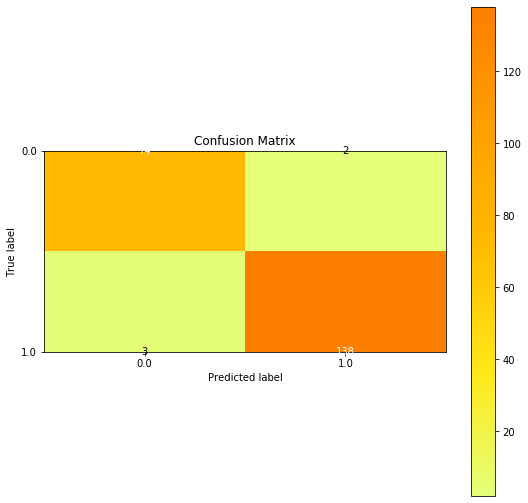

In [68]:
skplt.metrics.plot_confusion_matrix(y_test, y_prediction, normalize=False, figsize=(9,9),cmap='Wistia')
plt.show()

In [67]:
precision_score(y_test, y_prediction)

0.9857142857142858

In [65]:
recall_score(y_test, y_prediction)

0.9787234042553191

### Answer:
- Based on the metrics our False Negative value is 3 and and out True Positive value is 138 so chances of failing to detect sample with cancer is $FN/(TP+FN)*100=3/(138+3)*100=2.1276596$% or we can also calculate it using 1-Recall_score

### Q5.2
Display the decision boundary (use function decision_function()) together with a scatter plot of the data using the same features and figure layout as in the decision tree display for direct comparability. This time, use a suitable colormap (parameter “cmap”) in the contourf() function. Mark the support vectors. 

In [69]:
clf = SVC(C=1, gamma='auto', kernel='rbf')
clf.fit(x_train,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

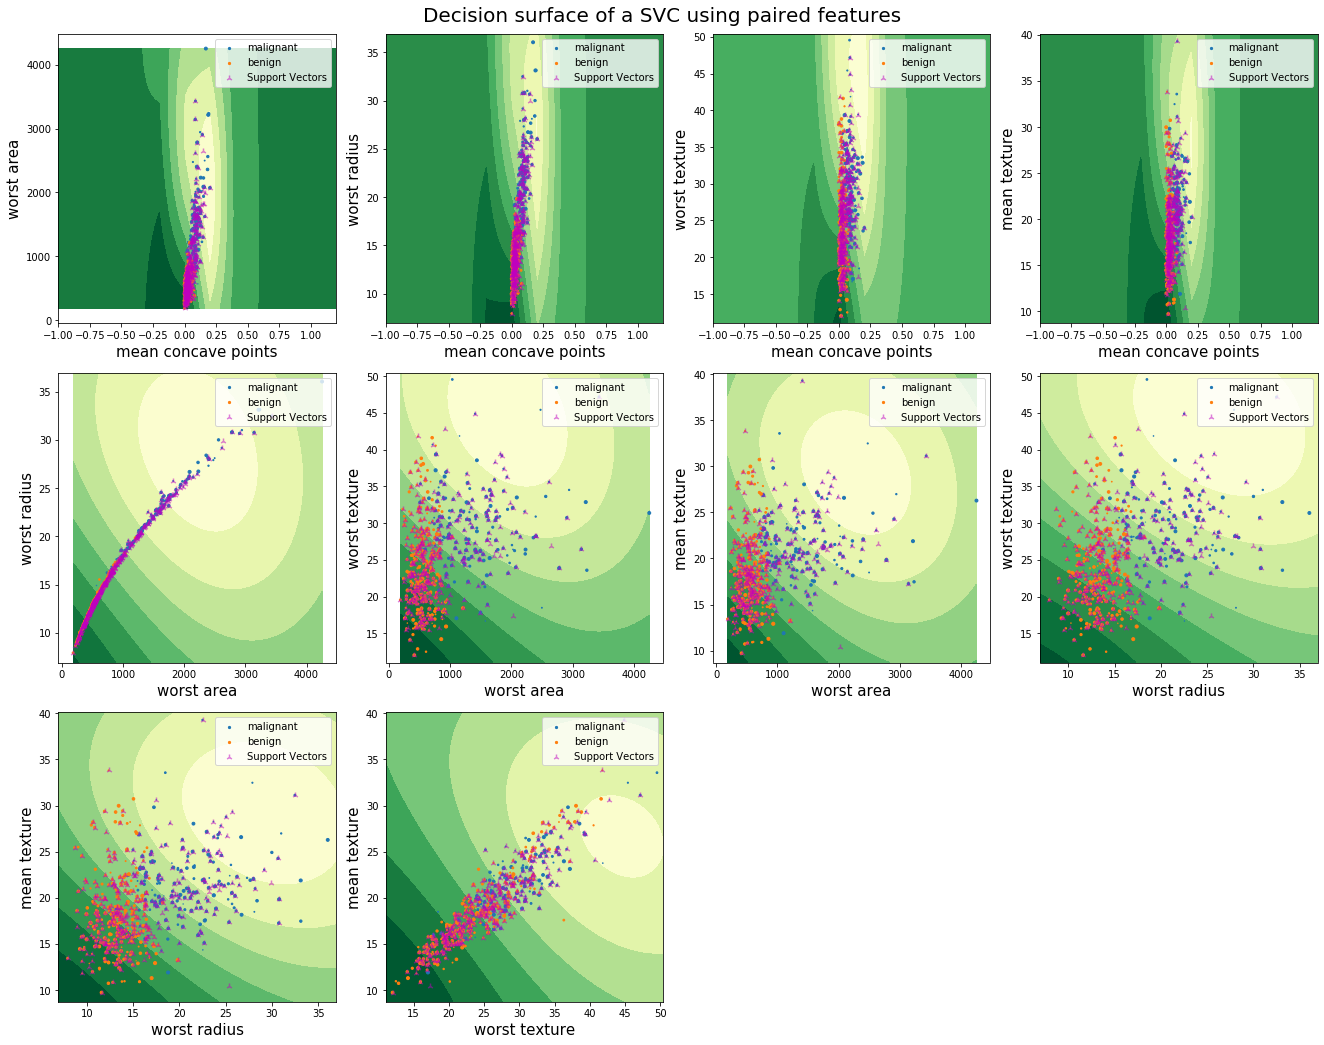

In [71]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 18.5)
import numpy as np
warnings.filterwarnings("ignore")


# Parameters
n_classes = 2
step_plot = .2

f1=column_index[0]
f2=column_index[1]
f3=column_index[2]
f4=column_index[3]
f5=column_index[4]
levels=np.arange(-0.1,10,0.1)

for pairid, pair in enumerate([[f1,f2] , [f1, f3], [f1, f4],[f1, f5],[f2, f3],
                                [f2, f4],[f2,f5], [f3,f4 ],[f3, f5], [f4, f5]]):
    # We only take the two corresponding features
    X = cancer.data[:, pair]
    y = cancer.target

    # Plot the decision boundary
    plt.subplot(4, 4, pairid + 1)
    # Make a meshgrid
    xmin, xmax = X[:, 0].min()-1 , X[:, 0].max()+1 
    ymin, ymax = X[:, 1].min()-1 , X[:, 1].max()+1 
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step_plot),
                         np.arange(ymin, ymax, step_plot))
    midpoint=((X[:, 1].mean(),X[:, 0].mean()))

    #Creating a new array to put the values of analysis point for the respective features by multiplying with analysis point 
    rows=xx.shape[0]*xx.shape[1]
    new_array=[]
    for i in range(rows):
        new_array.append([1]*30)
    new_array=np.array(new_array)
    new_array=np.c_[new_array]
    
    #Multiplying analysis point with new array
    analysis_point_array=np.array(analysis_point)
    new_array=new_array*analysis_point_array
    new_array[:,pair[0]]=xx.ravel()
    new_array[:,pair[1]]=yy.ravel()

    
    
    #Decision function and plot contours
    Z = pipeline1.decision_function(new_array)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z,cmap='YlGn')
    
    #labling the columns
    plt.xlabel(cancer.feature_names[pair[0]],size=15)
    plt.ylabel(cancer.feature_names[pair[1]],size=15)
    plt.axis("tight")

    # Plot the training points
    for i in zip(range(n_classes)):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1],levels,label=cancer.target_names[i],
                    cmap=plt.cm.RdYlGn)
    
    x_vector = []
    y_vector = []
    for i in clf.support_vectors_:
        x_vector.append(i[pair[0]])
        y_vector.append(i[pair[1]])
    plt.scatter(x_vector, y_vector, color='m', marker='2', alpha=0.5, label='Support Vectors')
    plt.axis("tight")
    plt.legend(loc = 'upper right')
    plt.tight_layout()

plt.suptitle("Decision surface of a SVC using paired features", size=20, y=1.010)

plt.show()

### Q5.3 
Question: What is the meaning of the support vectors? Where can we see their purpose in the diagrams?

### Answer:
- Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier. Deleting the support vectors will change the position of the hyperplane. These are the points that help us build our SVC.
- A support vector machine machine attempts to find the line that "best" separates two classes of points. By "best", we mean the line that results in the largest margin between the two classes. As we can see that support vectors are separating classes in the diagram.

### Q6	Compare the classifiers and interpret (15%)

### Q6.1
Question: Compare the classifier structures and decision boundaries of both classifiers. Point out similarities and differences. How do the classifiers compare outside the areas of dense sampling in the parameter space, e.g. towards the edges of the scatterplot (extrapolation)?

### Answer:
__Similarities:__ Both the classifier has high accuracy, precision and recall score which are 97.69 , 97.88 and 98.58 for Decision Tree and 97.69, 98.57 and 97.87 for SVC.
- SVM performs better than decision tree as it show much more clearer boundaries as compared to decision tree.

On observing these two decision boundary plot of Decision calssifier and SVC
Decision Trees show very similar patterns. The boundaries change in parallel to the coordinate axes which looks very unnatural.
The RBF SVM has very nice decision boundary. It is smooth, matches the pattern and is able to adjust to all three examles.

### Q6.2
Question: Generalisability: Do you see sources of bias in the two classifiers? Are the models showing any signs of overfitting (variance error)?

### Answer: 
The bias and the variance error in  both the classifiers are not that significant as both the classfier has good precision and recall score.
Also by seeing the confusion matrix we can say that bias and variance error is negligible in this classification and there is no sign of model getting overfit

### Q6.3
Question: Table 1 from Street et al. (1993) below shows the accuracies of their classifiers for different numbers of features and different numbers of hyperplanes used. Compare the number of features (decision tree), selection of features and accuracy of your classifiers with this table. Is there only one good set of features, many different sets or is there a pattern of similar feature combinations?

In [78]:
for i in range(1,20):
    clf1=DecisionTreeClassifier(criterion='gini',random_state=0,max_depth=7,min_samples_leaf=1,class_weight='balanced',max_features=i)
    clf1.fit(x_train,y_train)
    y_pred___=clf1.predict(x_test)
    score=accuracy_score(y_pred___,y_test)
    print("Accuracy of the classifier while selecting feature number",i,"is",round(score*100,2))

Accuracy of the classifier while selecting feature number 1 is 88.94
Accuracy of the classifier while selecting feature number 2 is 93.09
Accuracy of the classifier while selecting feature number 3 is 94.93
Accuracy of the classifier while selecting feature number 4 is 93.55
Accuracy of the classifier while selecting feature number 5 is 94.93
Accuracy of the classifier while selecting feature number 6 is 94.01
Accuracy of the classifier while selecting feature number 7 is 94.93
Accuracy of the classifier while selecting feature number 8 is 92.17
Accuracy of the classifier while selecting feature number 9 is 96.31
Accuracy of the classifier while selecting feature number 10 is 96.77
Accuracy of the classifier while selecting feature number 11 is 97.24
Accuracy of the classifier while selecting feature number 12 is 96.31
Accuracy of the classifier while selecting feature number 13 is 96.31
Accuracy of the classifier while selecting feature number 14 is 94.93
Accuracy of the classifier wh

### Answer:
We can see accurace score varies for different feature, Hence we can say that there is not specific amount of feature which will be helpful in getting good results. 

And by obseving how the values change with respect to the features we can see that there is no definitve pattern of features, infact we can infer from figure 1,2,3,4,5,6,7 and say that there are around 5,6 feature sets which are helpful for clasification.